In [2]:
# Jun Tu 21-732-722
# Guanda Zhao 21-716-345

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as sts

In [56]:
data_base_path = "Data/"

cormat_1h = np.load(data_base_path + "cormat_1h.npy")
cormat_1m = np.load(data_base_path + "cormat_1m.npy")
stocknames = np.loadtxt(data_base_path + "stocknames.txt", dtype=str)
stocknames_dict = {}

for i in range(0, len(stocknames)):
    stocknames_dict[i] = stocknames[i]

print("Loading is done")

## thread unsafe
figure_uni_index=0
def new_figure():
    global figure_uni_index
    figure_uni_index = figure_uni_index + 1
    fig = plt.figure(figure_uni_index)
    return fig


Loading is done


In [27]:
def lambda_min_max(Q):
    lambda_min = 1 + 1 / Q - 2 * math.sqrt(1/Q)
    lambda_max = 1 + 1 / Q + 2 * math.sqrt(1/Q)
    return lambda_min, lambda_max

def marcenko_pastur(Q, lambda_input):
    lambda_min, lambda_max = lambda_min_max(Q)
    probability = (Q / (2 * math.pi)) * (math.sqrt((lambda_max - lambda_input)*(lambda_input - lambda_min)) / lambda_input)
    return probability

def replace_noise(eigvals, noise, lambda_max):
    matrix = np.zeros((eigvals.shape[0], eigvals.shape[0]))
    count = 0
    i = 0
    for i in range(0, eigvals.shape[0]):
        eigval = eigvals[i]
        if (eigval < lambda_max):
            matrix[i][i] = noise[count]
            count += 1  
        else:
            matrix[i][i] = eigval
    return matrix

Text(0.5, 1.0, 'MP law for 1m')

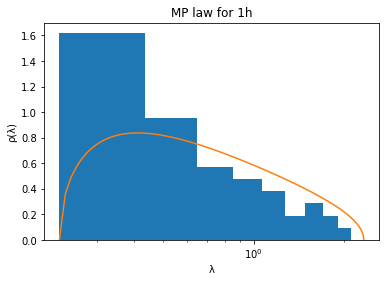

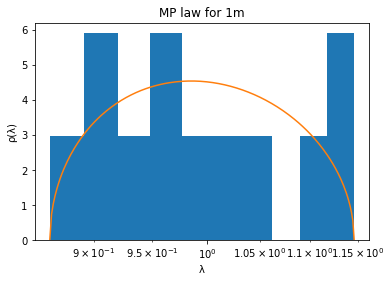

In [28]:
eigval_1h, eigvec_1h = np.linalg.eig(cormat_1h)
eigval_1m, eigvec_1m = np.linalg.eig(cormat_1m)

Q_1h = 3.6289
Q_1m = 200.8969

lambda_min_1h, lambda_max_1h = lambda_min_max(Q_1h)
lambda_min_1m, lambda_max_1m = lambda_min_max(Q_1m)

x_1h = np.arange(lambda_min_1h, lambda_max_1h, (lambda_max_1h - lambda_min_1h)/200)
x_1m = np.arange(lambda_min_1m, lambda_max_1m, (lambda_max_1m - lambda_min_1m)/200)
x_1h = np.append(x_1h, lambda_max_1h)
x_1m = np.append(x_1m, lambda_max_1m)

y_1h = [marcenko_pastur(Q_1h, x) for x in x_1h]
y_1m = [marcenko_pastur(Q_1m, x) for x in x_1m]

new_figure()
plt.hist(eigval_1h, range = (lambda_min_1h, lambda_max_1h), density = True)
plt.plot(x_1h, y_1h)
plt.xscale('log')
plt.xlabel('\u03BB')
plt.ylabel('\u03C1(\u03BB)')
plt.title('MP law for 1h')

new_figure()
plt.hist(eigval_1m, range = (lambda_min_1m, lambda_max_1m), density = True)
plt.plot(x_1m, y_1m)
plt.xscale('log')
plt.xlabel('\u03BB')
plt.ylabel('\u03C1(\u03BB)')
plt.title('MP law for 1m')

In [32]:
noise_1h = []
signal_1h = []
noise_1m = []
signal_1m = []

for eigval in eigval_1h:
    if (eigval < lambda_max_1h):
        noise_1h.append(eigval)
    else:
        signal_1h.append(eigval)
        
for eigval in eigval_1m:
    if (eigval < lambda_max_1m):
        noise_1m.append(eigval)
    else:
        signal_1m.append(eigval)
        
norm_noise_1h = [lambda_i / sum(noise_1h) * len(noise_1h) for lambda_i in noise_1h]
norm_noise_1m = [lambda_i / sum(noise_1m) * len(noise_1m) for lambda_i in noise_1m]

diagonal_1h = replace_noise(eigval_1h, norm_noise_1h, lambda_max_1h)
diagonal_1m = replace_noise(eigval_1m, norm_noise_1m, lambda_max_1m)

denoised_1h = eigvec_1h.dot(diagonal_1h).dot(np.linalg.inv(eigvec_1h))
denoised_1m = eigvec_1m.dot(diagonal_1m).dot(np.linalg.inv(eigvec_1m))

D_1h = np.zeros(denoised_1h.shape)
D_1m = np.zeros(denoised_1m.shape)

for i in range(0, denoised_1h.shape[0]):
    D_1h[i][i] = 1 / math.sqrt(denoised_1h[i][i])
    
for i in range(0, denoised_1m.shape[0]):
    D_1m[i][i] = 1 / math.sqrt(denoised_1m[i][i])

denoised_1h = D_1h.dot(denoised_1h).dot(D_1h)
denoised_1m = D_1m.dot(denoised_1m).dot(D_1m)

print('denoised_1h:\n', denoised_1h)
print('\n')
print('denoised_1m:\n', denoised_1m)

denoised_1h:
 [[1.         0.14692527 0.15940992 ... 0.07201036 0.01421172 0.10200188]
 [0.14692527 1.         0.33724734 ... 0.15917889 0.11284625 0.18945718]
 [0.15940992 0.33724734 1.         ... 0.27913275 0.11432449 0.14112075]
 ...
 [0.07201036 0.15917889 0.27913275 ... 1.         0.26350568 0.27682449]
 [0.01421172 0.11284625 0.11432449 ... 0.26350568 1.         0.35824278]
 [0.10200188 0.18945718 0.14112075 ... 0.27682449 0.35824278 1.        ]]


denoised_1m:
 [[1.         0.12031749 0.19389909 ... 0.16291595 0.19838505 0.20601955]
 [0.12031749 1.         0.14695473 ... 0.12858604 0.1652078  0.26106404]
 [0.19389909 0.14695473 1.         ... 0.12086124 0.18929927 0.22079134]
 ...
 [0.16291595 0.12858604 0.12086124 ... 1.         0.19520453 0.23550205]
 [0.19838505 0.1652078  0.18929927 ... 0.19520453 1.         0.26607777]
 [0.20601955 0.26106404 0.22079134 ... 0.23550205 0.26607777 1.        ]]


Text(0.5, 1.0, '1 hour vs 1 minute MST degrees of stocks')

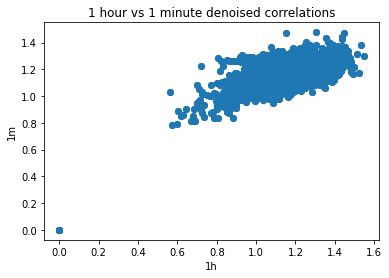

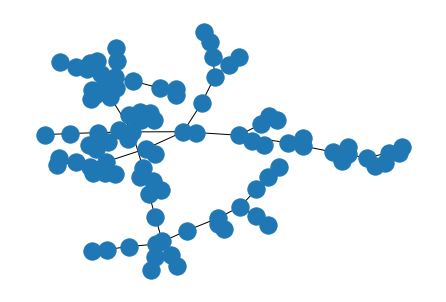

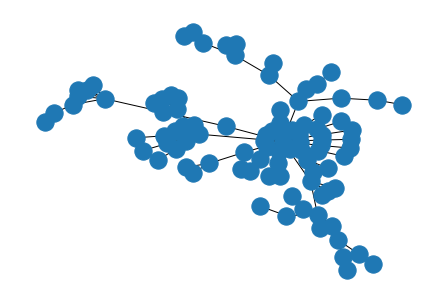

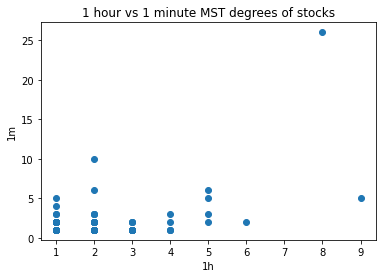

In [77]:
D_1h = np.zeros(cormat_1h.shape)
D_1m = np.zeros(cormat_1m.shape)

for i in range(0, cormat_1h.shape[0]):
    for j in range(0, cormat_1h.shape[1]):
        D_1h[i][j] = math.sqrt(2 * (1 - cormat_1h[i][j])) 

for i in range(0, cormat_1m.shape[0]):
    for j in range(0, cormat_1m.shape[1]):
        D_1m[i][j] = math.sqrt(2 * (1 - cormat_1m[i][j])) 
        
new_figure()
plt.scatter(x = D_1h, y = D_1m)
plt.xlabel('1h')
plt.ylabel('1m')
plt.title('1 hour vs 1 minute denoised correlations')

G_1h = nx.from_numpy_matrix(D_1h)
G_1m = nx.from_numpy_matrix(D_1m)
MST_1h = nx.minimum_spanning_tree(G_1h)
MST_1m = nx.minimum_spanning_tree(G_1m)

nx.set_node_attributes(MST_1h, stocknames_dict, 'name')
nx.set_node_attributes(MST_1m, stocknames_dict, 'name')

degrees_1h = []
degrees_1m = []

for i in range (0, len(stocknames)):
    degrees_1h.append(MST_1h.degree(i))
    degrees_1m.append(MST_1m.degree(i))
    
new_figure()
nx.draw(MST_1h)

new_figure()
nx.draw(MST_1m)

new_figure()
plt.scatter(x = degrees_1h, y = degrees_1m)
plt.xlabel('1h')
plt.ylabel('1m')
plt.title('1 hour vs 1 minute MST degrees of stocks')